In [1]:
#Goal: create word vectors from a HP dataset
#for word encoding
import csv
#regex
import glob
#concurrency
import multiprocessing
#dealing with operation system, like reading a file
import os
#pretty priting, human readable
import pprint
#regular expression
import re
#natural language processing
import nltk
from nltk.tokenize import sent_tokenize
#word 2 vec
import gensim.models.word2vec as w2v
#dimentionally reduction: "Visualize a dataset easily" -video
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse pandas as pd
import pandas as pd
#visualization
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [4]:
corpus_raw = []

In [5]:
with open('allreviews.csv', newline='', encoding='utf-8') as csvfile:
    next(csvfile, None) # skip first header line
    csvreader = csv.reader((x.replace('\0', '') for x in csvfile), delimiter=',', quotechar='"',quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for row in csvreader:
        corpus_raw.extend(sent_tokenize(row[1]))
        
print("Corpus is now {0} sentences long".format(len(corpus_raw)))

Corpus is now 12992821 sentences long


In [ ]:
# nltk.download("punkt")
# nltk.download("stopwords")

In [ ]:
#use NLTK to split corpus into sentences (load the pre-trained model)
# sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
# raw_sentences = sent_tokenize(corpus_raw)
# print(len(raw_sentences))

In [6]:
print(corpus_raw[12992800:])

['Such a great story line and is rated very well on IGN, Metacritic and Gamestop!', 'Would definitely recommend!', 'Hubby loves it, the game and the machine.', 'Great deal.', 'He has wanted one for years now.', 'I hope it lasts as long as our PS3!', "My sons hasn't stopped playing for days.", 'Shipped quick.', 'Packaged great.', 'Works perfect.', 'Great gaming console, not mch to say considering that it does all I want', 'AGreat deal until prime day came around.', 'Shucks!', 'My 13 yr old loves it, bundle was worth it', "There's not much I can say that hasn't already been said.", "So with that, I'll just say that Sony has once again, exceeded my expectations.", 'received on time as promised .', 'Having a small issue with the play station flickering on the screen when it first starts up.', 'Got it for $220 With uncharted4.', "Never owned a playstation but it's working great.", 'Hell of a deal']


In [7]:
#convert into a list of words
#remove unnecessary comma, split into words, no hypens
#list of words (regex) only getting things that involve english (a-z or A-Z)
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-z]"," ",raw)
    words = clean.split()
    return words

In [11]:
corpus_raw[12992720]

'The kids are thrilled, especially since it came with a game.'

In [12]:
sentence_to_wordlist(corpus_raw[12992720])

['The',
 'kids',
 'are',
 'thrilled',
 'especially',
 'since',
 'it',
 'came',
 'with',
 'a',
 'game']

In [14]:
token_sentences = []
for raw_sentence in corpus_raw:
    if len(raw_sentence) > 0:
        token_sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
len(corpus_raw)

12992821

In [16]:
len(token_sentences)

12992821

In [17]:
print("the sentence has {0} words or tokens".format(len(token_sentences[12992720])))

the sentence has 11 words or tokens


In [18]:
token_count = sum([len(sentence) for sentence in token_sentences])
print("The amazon review corpus contains {0:,} words or tokens".format(token_count))

The amazon review corpus contains 233,466,322 words or tokens


In [22]:
#ONCE we have vectors. 
#3 main tasks that vectors help with
#Distance, Similarity, Ranking

#(Vector is a type of tensor)

#Dimensionality of the resulting word vectors
#the more dimension (more generalize), the more computinally expensive to train
#but also more accurate
num_features = 300

#minimum word count threashold
min_word_count = 3

#number of threads to run in parallel
#the more workers, the faster we train
num_workers = multiprocessing.cpu_count()

#context window length
#a size of window (number of objects we are looking at a time).
context_size = 5

#Downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#Seed for the Random Number Generator, to make the result
#pick what part the text we are going to look at and turn to vector
#deterministics, good for debugging
seed = 1

In [23]:
Amazon2vec = w2v.Word2Vec(
    sg=1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample=downsampling
)

In [24]:
Amazon2vec.build_vocab(token_sentences)

In [25]:
#clear corpus
del corpus_raw

In [ ]:
#clear raw_sentences
# del raw_sentences

In [26]:
print("Word2Vec vocabulary length:", len(Amazon2vec.wv.vocab))

Word2Vec vocabulary length: 169507


In [27]:
Amazon2vec.train(token_sentences,total_examples=Amazon2vec.corpus_count, epochs=Amazon2vec.iter)

882079843

In [28]:
#save the trained model to use later
if not os.path.exists("AmazonW2VtrainedNotLowerNew"):
    os.makedirs("AmazonW2VtrainedNotLowerNew")

In [29]:
Amazon2vec.save(os.path.join("AmazonW2VtrainedNotLowerNew","AmazonW2VtrainedNotLowerNew.w2v"))

In [30]:
#Example of loading the trained model
AmazonToVec = w2v.Word2Vec.load(os.path.join("AmazonW2VtrainedNotLowerNew","AmazonW2VtrainedNotLowerNew.w2v"))

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_word_vectors_matrix = AmazonToVec.wv.syn0
all_word_vectors_matrix_2d = pca.fit_transform(all_word_vectors_matrix)

In [34]:
#plot point in 2D space
points = pd.DataFrame(
[
    (word, coords[0], coords[1])
    for word, coords in [
        (word, all_word_vectors_matrix_2d[AmazonToVec.wv.vocab[word].index])
        for word in AmazonToVec.wv.vocab
    ]
],
columns=["word","x","y"]
)

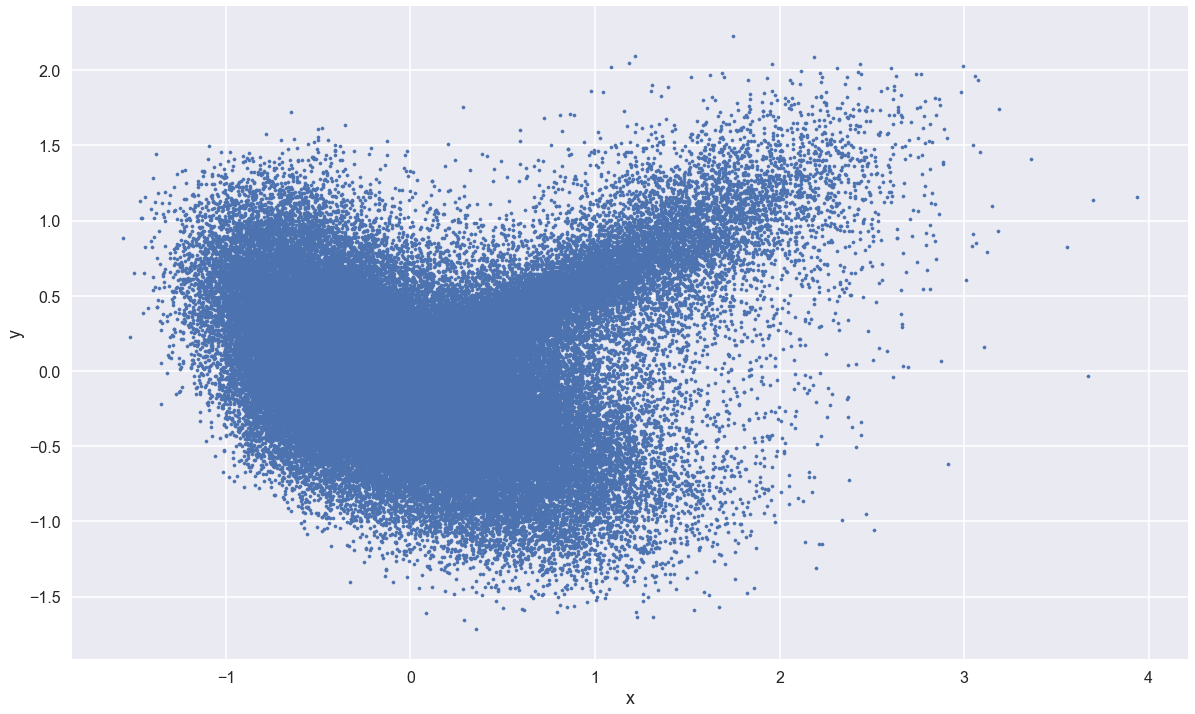

In [35]:
sns.set_context("poster")
points.plot.scatter("x","y", s=10, figsize=(20,12))